Class Encoding Mapping: {'hard': 0, 'sandy': 1, 'rocky': 2}


/Users/champakjyotikonwar/CODING/PROJECTS/Yantranav/nits-yantrarnav/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [23:48:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/champakjyotikonwar/CODING/PROJECTS/Yantranav/nits-yantrarnav/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [23:48:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/champakjyotikonwar/CODING/PROJECTS/Yantranav/nits-yantrarnav/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [23:48:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/champakjyotikonwar/CODING/PROJECTS/Yantranav/nits-yantrarnav/.venv/lib/python3.10/site-packages/

Best RF Params: {'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best XGB Params: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.8}


/Users/champakjyotikonwar/CODING/PROJECTS/Yantranav/nits-yantrarnav/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [23:48:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/champakjyotikonwar/CODING/PROJECTS/Yantranav/nits-yantrarnav/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [23:48:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/champakjyotikonwar/CODING/PROJECTS/Yantranav/nits-yantrarnav/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [23:48:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/champakjyotikonwar/CODING/PROJECTS/Yantranav/nits-yantrarnav/.venv/lib/python3.10/site-packages/

Final Ensemble Accuracy: 0.8765
Final Ensemble F1 Score: 0.8765


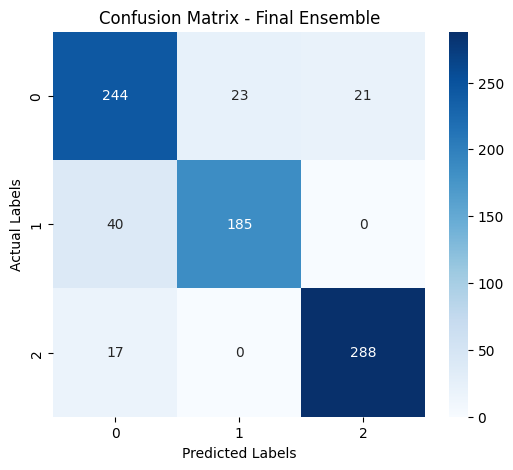

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# ---------------------------
# Data Loading & Preprocessing
# ---------------------------
file_path = "FINAL_RESULT.csv"  # Update path if needed
df = pd.read_csv(file_path)

# Drop 'Filename' column if it exists
if "Filename" in df.columns:
    df.drop(columns=["Filename"], inplace=True)

# Map class labels
class_mapping = {"hard": 0, "sandy": 1, "rocky": 2}
df["Class"] = df["Class"].map(class_mapping)
print("Class Encoding Mapping:", class_mapping)

# Split into features and target
X = df.drop(columns=["Class"])
y = df["Class"]

# Train-Test Split (Stratified)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# ---------------------------
# Hyperparameter Tuning using GridSearchCV
# ---------------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Random Forest Parameter Grid
rf_params = {
    "n_estimators": [100, 200],
    "max_depth": [10, 15],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2]
}

# XGBoost Parameter Grid
xgb_params = {
    "n_estimators": [100, 200],
    "learning_rate": [0.1, 0.2],
    "max_depth": [3, 6],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}

# Tune RandomForest
rf = RandomForestClassifier(random_state=42)
rf_grid = GridSearchCV(rf, rf_params, cv=cv, scoring="f1_weighted", n_jobs=-1)
rf_grid.fit(X_train, y_train)
best_rf = rf_grid.best_estimator_

# Tune XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42)
xgb_grid = GridSearchCV(xgb, xgb_params, cv=cv, scoring="f1_weighted", n_jobs=-1)
xgb_grid.fit(X_train, y_train)
best_xgb = xgb_grid.best_estimator_

print("Best RF Params:", rf_grid.best_params_)
print("Best XGB Params:", xgb_grid.best_params_)

# ---------------------------
# Train Final Stacking Model
# ---------------------------
stack_clf = StackingClassifier(
    estimators=[("rf", best_rf), ("xgb", best_xgb)],
    final_estimator=LogisticRegression(max_iter=1000),
    cv=cv
)

stack_clf.fit(X_train, y_train)
y_pred = stack_clf.predict(X_test)

# Metrics
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average="weighted")
print(f"Final Ensemble Accuracy: {acc:.4f}")
print(f"Final Ensemble F1 Score: {f1:.4f}")

# ---------------------------
# Confusion Matrix Visualization
# ---------------------------
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.title("Confusion Matrix - Final Ensemble")
plt.show()
